In [1]:
import numpy as np
import torch
from src import kernel_flow, datagen
import tqdm

## Regular Henon

### 1 step

In [2]:
# generate dataset
Data = datagen.Henon(T=200, dt=0.1,N_sims=1,a=1.4,b=0.3)[0]
#train test split
observed_data= Data
train_data = Data[:600,:].T
test_data = Data[600:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data(test_data,delay,normalize)

model = kernel_flow.train_kernel(X_train, Y_train, "anl3", nparameters, regu_lambda, lr = 0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.46it/s]


In [22]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
Y_pred = model.predict(torch.Tensor(X_test).double())

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0000


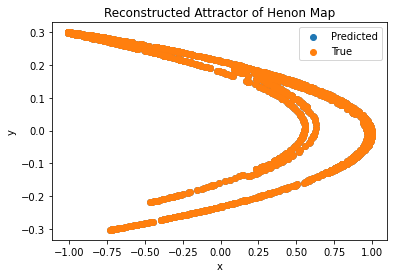

In [23]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### n steps interval

In [44]:
n = 3

# generate dataset
Data = datagen.Henon(T=200, dt=0.1,N_sims=1,a=1.4,b=0.3)[0]
#train test split
observed_data= Data[0::n]
train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data(test_data,delay,normalize)

model = kernel_flow.train_kernel(X_train, Y_train, "anl3", nparameters, regu_lambda, lr = 0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.24it/s]


In [45]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
Y_pred = model.predict(torch.Tensor(X_test).double())

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0001


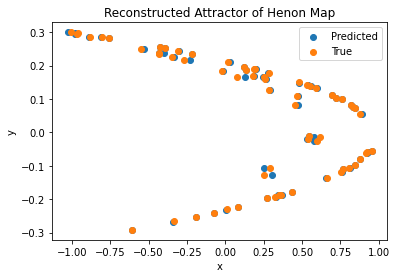

In [46]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## With irregular sampling

In [82]:
max_delay = 3
N_points = 1000
dt = 0.1

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx/dt)
# generate dataset
Data = datagen.Henon(T=T, dt=dt,N_sims=1,a=1.4,b=0.3)[0]
#train test split

observed_data = Data[indices]

train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data(test_data,delay,normalize)

model = kernel_flow.train_kernel(X_train, Y_train, "anl3", nparameters, regu_lambda, lr = 0.1,verbose = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.28it/s]


In [83]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
Y_pred = model.predict(torch.Tensor(X_test).double())

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.1274


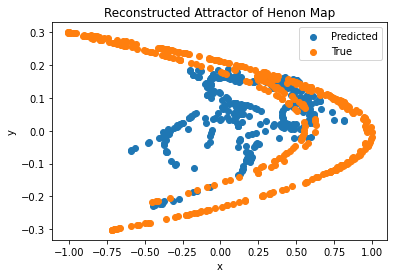

In [84]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## With irregular kernel flow

In [3]:
max_delay = 3
N_points = 1000
dt = 0.1

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx/dt)
# generate dataset
Data = datagen.Henon(T=T, dt=dt,N_sims=1,a=1.4,b=0.3)[0]
#train test split

observed_data = Data[indices]

train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T
delays_train = delays[:600]
delays_test = delays[600:]

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_irregular_data(train_data,delay,normalize, delays_train)
X_test, Y_test = datagen.prepare_irregular_data(test_data,delay,normalize, delays_test)


model = kernel_flow.train_kernel(X_train, Y_train, "anl3", nparameters, regu_lambda, lr = 0.1,verbose = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.56it/s]


In [4]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
Y_pred = model.predict(torch.Tensor(X_test).double())

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0001


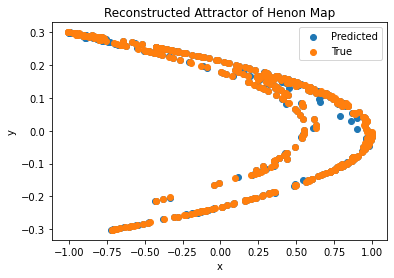

In [5]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [6]:
train_data.shape

(2, 600)